The purpose of this notebook is to analyze the good_reads dataset provided by Soumik on Kaggle.  First, we load the dataset into a data frame object.

In [609]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [610]:
books = pd.read_csv('books.csv', error_bad_lines=False)
books

b'Skipping line 4012: expected 10 fields, saw 11\nSkipping line 5688: expected 10 fields, saw 11\nSkipping line 7056: expected 10 fields, saw 11\nSkipping line 10601: expected 10 fields, saw 11\nSkipping line 10668: expected 10 fields, saw 11\n'


,bookID,title,authors,average_rating,isbn,isbn13,language_code,# num_pages,ratings_count,text_reviews_count
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling-Mary GrandPré,4.56,0439785960,9780439785969,eng,652,1944099,26249
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling-Mary GrandPré,4.49,0439358078,9780439358071,eng,870,1996446,27613
2,3,Harry Potter and the Sorcerer's Stone (Harry P...,J.K. Rowling-Mary GrandPré,4.47,0439554934,9780439554930,eng,320,5629932,70390
3,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.41,0439554896,9780439554893,eng,352,6267,272
4,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling-Mary GrandPré,4.55,043965548X,9780439655484,eng,435,2149872,33964
...,...,...,...,...,...,...,...,...,...,...
13709,47699,M Is for Magic,Neil Gaiman-Teddy Kristiansen,3.82,0061186422,9780061186424,eng,260,11317,1060
13710,47700,Black Orchid,Neil Gaiman-Dave McKean,3.72,0930289552,9780930289553,eng,160,8710,361
13711,47701,InterWorld (InterWorld #1),Neil Gaiman-Michael Reaves,3.53,0061238961,9780061238963,en-US,239,14334,1485
13712,47708,The Faeries' Oracle,Brian Froud-Jessica Macbeth,4.43,0743201116,9780743201117,eng,224,1550,38


In [611]:
books.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', '# num_pages', 'ratings_count', 'text_reviews_count'],
      dtype='object')

Looking at the columns available to us, I can think of the following questions.  1.) Can we predict the rating of a based based primarily on the number of pages and number of reviews?

Let's see if there is any data cleaning to be done.  Let's count the number of nulls.

In [612]:
books.isnull().sum(axis=0)

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
# num_pages           0
ratings_count         0
text_reviews_count    0
dtype: int64

The data appears to be very clean already, which will save us a lot of time.

One thing we should do remove columns which serve no interest to our machine learning algorithms.  Fir instance, we really don't care too much about bookId, title, authors, isbn numbers, or language codes.  So let's just drop those columns.

In [613]:
books = books.drop(['bookID', 'title', 'authors', 'isbn', 'isbn13', 'language_code'], axis=1)
books

,average_rating,# num_pages,ratings_count,text_reviews_count
0,4.56,652,1944099,26249
1,4.49,870,1996446,27613
2,4.47,320,5629932,70390
3,4.41,352,6267,272
4,4.55,435,2149872,33964
...,...,...,...,...
13709,3.82,260,11317,1060
13710,3.72,160,8710,361
13711,3.53,239,14334,1485
13712,4.43,224,1550,38


Now we generate a test set.  Since our dataset is rather large and the number of attributes we are cosnidering is rather small, we can use random sampling to generate a test set.  We need not use stratified sampling.

In [614]:
train_set, test_set = train_test_split(books, test_size=0.2, random_state=5)

Now, let us explore our data in more detail.  First, let's find the correlation matrix and its entries.

In [615]:
corr_matrix = books.corr()
corr_matrix['average_rating'].sort_values(ascending=False)

average_rating        1.000000
# num_pages           0.167388
ratings_count         0.041234
text_reviews_count    0.036695
Name: average_rating, dtype: float64

It is somewhat expected that no attribute is extremely correlated with the average rating.  It's also expected that the number of pages attribute is most positively correlated since longer books have more time to develop characters and plot.  Of course this isn't universally true, which is why we only see a 0.16 correlation.
  
Also of note is the slight positive correlation of review count to average rating.  I will investigate this eventually, but I suspect that the majority of people who spend their time to rate or review a book felt strongly about it, either positively or negatively.  So highly polarizing books draw large review counts, and the positive correlation between average rating and review counts tells me that the positive reviews win out.  This is all just hypothesis at this point, though.

The next step is to plot and see if we can see the relationships.

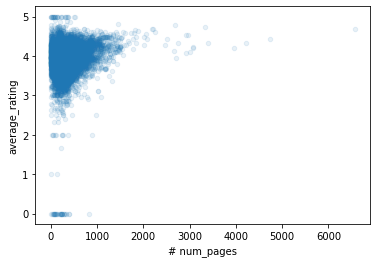

In [616]:
books.plot(kind="scatter", x="# num_pages", y="average_rating", alpha=0.1)

This has revealed some obvious things that I didn't think about before.  The lines at exactly 0, 1, 2, 3, 4, and 5 are probably extremely rare books that have only 1 or 2 reviews.  Those out-of-place horizontal lines on our plot introduce some error, and so we should get rid of them.

In [617]:
len(books[books['ratings_count'] == 1])

114

There is 114 books with only 1 rating.  Let's remove those entries.

In [618]:
books = books[books['ratings_count'] != 1]
books.reset_index(drop=True, inplace=True)
books

,average_rating,# num_pages,ratings_count,text_reviews_count
0,4.56,652,1944099,26249
1,4.49,870,1996446,27613
2,4.47,320,5629932,70390
3,4.41,352,6267,272
4,4.55,435,2149872,33964
...,...,...,...,...
13595,3.82,260,11317,1060
13596,3.72,160,8710,361
13597,3.53,239,14334,1485
13598,4.43,224,1550,38


Now, let's replot what we plotted before.

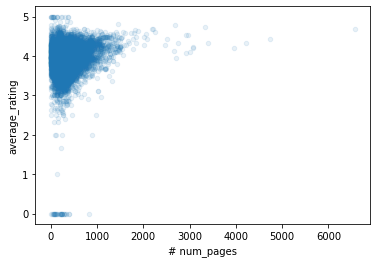

In [619]:
books.plot(kind="scatter", x="# num_pages", y="average_rating", alpha=0.1)

This has helped, but it has certainly not fixed the problem.  Let's continue removing entries with 10 or less ratings.  Hopefully, by then the horizontal lines will be gone.

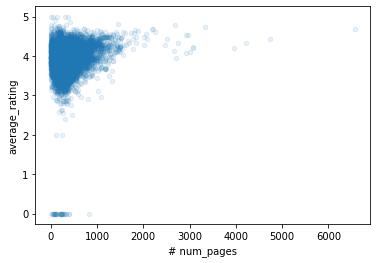

In [620]:
for num in range(2, 11):
    books = books[books['ratings_count'] != num]
    books.reset_index(drop=True, inplace=True)
books.plot(kind="scatter", x="# num_pages", y="average_rating", alpha=0.1)

Most of the lines have significantly been reduced, but the line at 0 is persistent.  Maybe there are just some really hated books.  Have the correlation coefficients changed much?

In [621]:
corr_matrix = books.corr()
corr_matrix['average_rating'].sort_values(ascending=False)

average_rating        1.000000
# num_pages           0.176003
ratings_count         0.041940
text_reviews_count    0.036244
Name: average_rating, dtype: float64

This is a good sign.  Removing some of the noise has increased correlations.  The original length of our dataframe was 13714.  By removing a bunch of entries, have we signifanctly reduced the size of our data?

In [622]:
len(books)

12775

A little less than 1000 data points.  We still have ample amounts data to work with, but now we feel much more confident that each book was rated by a significant number of people.

To be on the safe side, before we create models, let's perform some feature scaling via standardization.

In [623]:
train_X = train_set[['# num_pages', 'ratings_count', 'text_reviews_count']].copy()
train_y = train_set[['average_rating']].copy()
test_X = test_set[['# num_pages', 'ratings_count', 'text_reviews_count']].copy()
test_y = test_set[['average_rating']].copy()

In [624]:
std_scaler = StandardScaler()
train_X_prepared = std_scaler.fit_transform(train_X)

In [625]:
std_scaler.mean_

array([  342.17783247, 18655.23954061,   544.10172272])

In [626]:
std_scaler.var_

array([6.39902990e+04, 1.46045275e+10, 6.44003386e+06])

Now we are ready to create and test our models.  Before we start, we write a function that makes displaying the performance easier. 

In [627]:
def printRMSE(labels, predictions):
    mse = mean_squared_error(labels, predictions)
    rmse = np.sqrt(mse)
    print(rmse)
    
def perform10FoldCrossValidation(model, train, test):
    scores = cross_val_score(model, train, test, scoring="neg_mean_squared_error", cv=10)
    rmse_scores = np.sqrt(-scores)
    print("Scores: ", rmse_scores)
    print("Mean: ", rmse_scores.mean())
    print("Standard Deviation: ", rmse_scores.std())

First we try a linear regression model.

In [628]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(train_X_prepared, train_y)
perform10FoldCrossValidation(lin_reg_model, train_X_prepared, train_y)

Scores:  [0.34214109 0.31073957 0.35123809 0.3273335  0.32380197 0.39861553
 0.40228715 0.34326034 0.30459309 0.3811024 ]
Mean:  0.34851127448640357
Standard Deviation:  0.033097744296914755


*insert some analysis here*

Now let's try some other models, such as a Decision Tree and Random Forest model.

In [629]:
tree_reg_model = DecisionTreeRegressor()
tree_reg_model.fit(train_X_prepared, train_y)
perform10FoldCrossValidation(tree_reg_model, train_X_prepared, train_y)

Scores:  [0.4667841  0.41072254 0.42438873 0.38888326 0.44209374 0.48790359
 0.47016699 0.42435086 0.41089508 0.50266533]
Mean:  0.4428854221952734
Standard Deviation:  0.03546273389946043


In [630]:
forest_reg_model = RandomForestRegressor()
forest_reg_model.fit(train_X_prepared, train_y.values.ravel())
perform10FoldCrossValidation(forest_reg_model, train_X_prepared, train_y.values.ravel())

Scores:  [0.36931703 0.31234242 0.31853246 0.30195872 0.3420599  0.40283483
 0.36056085 0.32430694 0.31228846 0.39018044]
Mean:  0.3434382048218775
Standard Deviation:  0.03364772788402814


The Random Forest model seems to have the most potential.  We can now fine tune the model to find the best combinations of hyper parameters in the Random Forest model.  To do this, we use Grid Search.

In [631]:
def perform_random_forest_grid_search(X_prepared, y):
    param_grid = [{'n_estimators': [35,36,37], 'max_features': [0.04, 0.05, 0.07]},
                 ]
    forest_reg = RandomForestRegressor()
    grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True)
    grid_search.fit(X_prepared, y)
    print(grid_search.best_params_)

After some tinkering with the above method, I think I have a good idea for some of the hyper parameters.  We will let n_estimators = 37 and max_features = 0.05.  Let us see if our model performs better with these hyper parameters.

In [632]:
forest_reg_model_gs = RandomForestRegressor(n_estimators=37, max_features=0.05)
forest_reg_model_gs.fit(train_X_prepared, train_y.values.ravel())
perform10FoldCrossValidation(forest_reg_model_gs, train_X_prepared, train_y.values.ravel())

Scores:  [0.36068485 0.31036391 0.32098634 0.30036058 0.34318003 0.40201757
 0.35256139 0.32023775 0.30900027 0.38757965]
Mean:  0.340697233497816
Standard Deviation:  0.032959878564105934


It really did not help much.  It seems that the default values for hyper parameters in the Random Forest Regressor do a good job of optimizing the results in this case.

The last thing to do is to evaluate the model on the test set.  First though, we should perform the same feature scaling we did before (the only difference is we are not fitting our standard scaler object to the test data, we are only transforming it).

In [633]:
test_X_prepared = std_scaler.transform(test_X)

In [634]:
test_predictions = forest_reg_model.predict(test_X_prepared)
printRMSE(test_y, test_predictions)

0.36216158181818175


That concludes this mini-project.  We were able to predict a books rating within about 0.36.  Given the distribution of good reads scores, this isn't entirely impressive.  But the number of useful attributes in our data was not very much to begin with, so the models did not have much to go off of.  In the end, if we got results any closer than we did, it would probably indicate over-fitting.  To progress further in the quest to predict good reads scores, we would need more data.  Not necessarily more entries, since we had plenty with this data set, but more interesting columns.  It would be interesting to see how a books genre might affect its good reads score.  Adding the genre among other attributes could help the models become more accurate.